# Ejercicio 1: análisis de datos económicos
*Rodrigo Leo*

**Objetivo**: usando datos de varias fuentes, obtener indicadores económicos relevantes de México y el mundo, así como relaciones entre ellos, y proyectar su evolución en el corto y mediano plazo.

---

Importar paquetes requeridos (`pandas` para el manejo de las bases de datos `matplotlib` y `seaborn` para graficar, y `statsmodels` para ajustar modelos estadísticos):

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

La siguiente celda de código contiene parámetros y funciones utilizadas a lo largo del resto del documento.

In [2]:
# Silenciar advertencias de IPython:
import warnings
warnings.filterwarnings('ignore')

# Establecer estilo de los gráficos:
sns.set_theme(style="white")

# La función longitud() devuelve el tamaño de los datos en el eje Y de un gráfico pasado como parámetro:
def longitud(g):
    return len(g.ax.lines[0].get_ydata())

# La función guardar() guarda el gráfico pasado como parámetro como un archivo *.png en el directorio 'Figuras':
def guardar(g, nombre):
    g.savefig(f'figuras/{nombre}.png', dpi=300)

## 1. PIB trimestral

Para el análisis del PIB trimestral empleamos la tabla `gdp_quarterly_imf.csv`:

In [3]:
# Cargar base de datos:
pib_trimestral = pd.read_csv('bases_de_datos/pib_trimestral.csv')

# Transformar los datos de formato wide a long:
pib_trimestral = pib_trimestral.melt(id_vars = ['País', 'Fuente', 'Variación'], var_name = 'Periodo', value_name = 'Variación porcentual')

# Tranformar los datos de periodo a tipo PeriodIndex, con frecuencia trimestral:
pib_trimestral['Periodo'] = pd.PeriodIndex(pib_trimestral['Periodo'], freq = 'Q')

# Introducir columna de fecha (de PeriodIndex a timestamp):
pib_trimestral['Fecha'] = pib_trimestral['Periodo'].dt.to_timestamp()

Gráfico del crecimiento del PIB trimestral de México y Estados Unidos, con respecto al mismo trimestre del año anterior, desde 2019 Q1 hasta 2021 Q2:

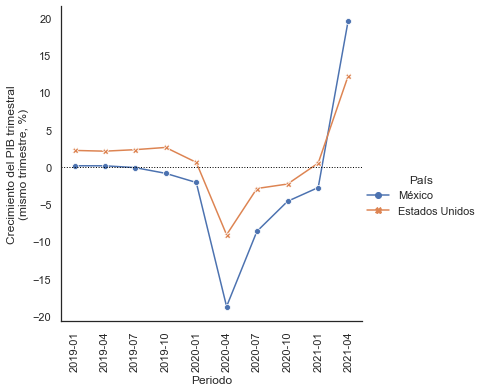

In [4]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Variación porcentual',
    kind = 'line',
    hue = 'País',
    style = 'País',
    markers = True,
    dashes = False,
    data = pib_trimestral.query("Fecha >= '2019-01-01' & Variación == 'Mismo trimestre del año anterior'")
).set(
    xlabel = 'Periodo',
    ylabel = 'Crecimiento del PIB trimestral\n(mismo trimestre, %)'
)

g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')
g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)

guardar(g, 'pib_trimestral_mismo_trimestre')

Gráfico del crecimiento del PIB trimestral de México y Estados Unidos, con respecto al trimestre inmediatamente anterior, desde 2019 Q1 hasta 2021 Q1:

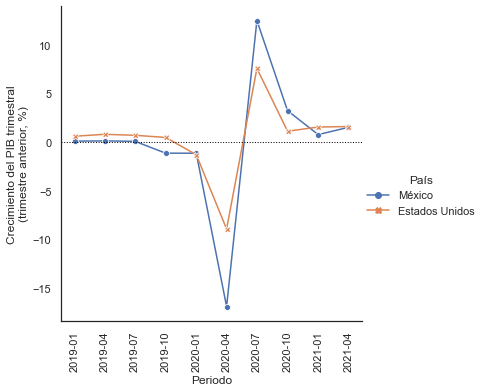

In [5]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Variación porcentual',
    kind = 'line',
    hue = 'País',
    style = 'País',
    markers = True,
    dashes = False,
    data = pib_trimestral.query("Fecha >= '2019-01-01' & Variación == 'Trimestre inmediatamente anterior'")
).set(
    xlabel = 'Periodo',
    ylabel = 'Crecimiento del PIB trimestral\n(trimestre anterior, %)'
)

g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')
g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)

guardar(g, 'pib_trimestral_trimestre_anterior')

Tabla de variación porcentual respecto al trimestre inmediatamente anterior:

In [6]:
pib_trimestral.query("Variación == 'Trimestre inmediatamente anterior' & Fecha >= '2020-01-01'").sort_values(['País', 'Periodo'])[[
    'País',
    'Periodo',
    'Variación porcentual'
]].style.hide_index()

País,Periodo,Variación porcentual
Estados Unidos,2020Q1,-1.300136
Estados Unidos,2020Q2,-8.925434
Estados Unidos,2020Q3,7.550895
Estados Unidos,2020Q4,1.106499
Estados Unidos,2021Q1,1.539102
Estados Unidos,2021Q2,1.586828
México,2020Q1,-1.148323
México,2020Q2,-16.870896
México,2020Q3,12.462912
México,2020Q4,3.214057


Tabla de variación porcentual respecto al mismo trimestre del año anterior:

In [7]:
pib_trimestral.query("Variación == 'Mismo trimestre del año anterior' & Fecha >= '2020-01-01'").sort_values(['País', 'Periodo'])[[
    'País',
    'Periodo',
    'Variación porcentual'
]].style.hide_index()

País,Periodo,Variación porcentual
Estados Unidos,2020Q1,0.600000
Estados Unidos,2020Q2,-9.100000
Estados Unidos,2020Q3,-2.900000
Estados Unidos,2020Q4,-2.300000
Estados Unidos,2021Q1,0.500000
Estados Unidos,2021Q2,12.200000
México,2020Q1,-2.094132
México,2020Q2,-18.705056
México,2020Q3,-8.640763
México,2020Q4,-4.613852


## 2. Vacunación

Para las estadísticas de vacunación contra el COVID-19 se utiliza la base de datos `vaccines.csv`:

In [8]:
# Cargar base de datos:
vac = pd.read_csv('bases_de_datos/vaccines.csv')

# Transformar fechas en tipo datetime:
vac['Fecha'] = pd.to_datetime(vac['Fecha'])

# Reemplazar nombres de países por equivalentes en español:
vac['País'] = vac['País'].map({
    'Mexico': 'México',
    'United States': 'Estados Unidos',
    'World': 'Mundo'
})

# Eliminar filas vacías:
vac = vac.dropna()

# Calcular porcentaje de la población con al menos una dosis:
vac['Población vacunada'] = vac['Personas vacunadas'] / vac['Población'] * 100

# Calcular tasa de vacunación:
vac = vac.sort_values('Fecha')
vac['Tasa de vacunación'] = vac.groupby('País')['Población vacunada'].transform(lambda x: (x - x.shift()) / x.shift() * 100)

# Limpiar observaciones vacías:
vac = vac.dropna()
vac = vac.query("`Tasa de vacunación` != inf")

vac = vac.set_index('Fecha')

Gráfico de la proporción de la población vacunada (con al menos una dosis) en México y Estados Unidos. La línea roja corresponde a la proporción de la población mundial con al menos una dosis en el periodo final de la muestra:

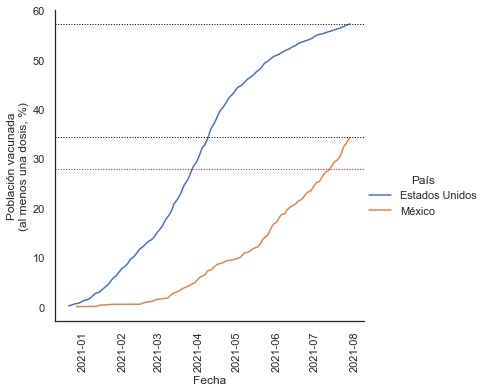

In [9]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Población vacunada',
    kind = 'line',
    hue = 'País',
    style = 'País',
    markers = False,
    dashes = False,
    data = vac.query("País in ('México', 'Estados Unidos')")
).set(
    xlabel = 'Fecha',
    ylabel = 'Población vacunada\n(al menos una dosis, %)'
)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)
g.ax.axhline(max(vac.query("País == 'México'")['Población vacunada']), color = 'black', linewidth = '1', linestyle = 'dotted')
g.ax.axhline(max(vac.query("País == 'Estados Unidos'")['Población vacunada']), color = 'black', linewidth = '1', linestyle = 'dotted')
g.ax.axhline(max(vac.query("País == 'Mundo'")['Población vacunada']), color = 'red', linewidth = '1', linestyle = 'dotted')

guardar(g, 'vacunacion')

Tabla comparativa de la proporción de población vacunada:

In [10]:
vac.query("Fecha in ('2021-01-04', '2021-04-30', '2021-07-28')")[[
    'País',
    'Población vacunada'
]].style.format(formatter = {
    'Población vacunada': '{:.2f}%'
})

,País,Población vacunada
Fecha,,
2021-01-04 00:00:00,Mundo,0.12%
2021-01-04 00:00:00,Estados Unidos,1.38%
2021-01-04 00:00:00,México,0.03%
2021-04-30 00:00:00,México,9.68%
2021-04-30 00:00:00,Estados Unidos,43.77%
2021-04-30 00:00:00,Mundo,7.71%
2021-07-28 00:00:00,México,34.27%
2021-07-28 00:00:00,Estados Unidos,57.25%
2021-07-28 00:00:00,Mundo,27.80%


## 3. Inflación

Para el cálculo de la inflación utilizamos la base de datos `cpi.csv` que contiene información del índice de precios al consumidor mensual:

In [11]:
ipc = pd.read_csv('bases_de_datos/cpi.csv')
ipc = ipc.melt(id_vars = 'País', var_name = 'Fecha', value_name = 'IPC')
ipc['Fecha'] = pd.to_datetime(ipc['Fecha'])
ipc['Periodo'] = pd.PeriodIndex(ipc['Fecha'], freq = 'M')
ipc = ipc.sort_values('Fecha')
ipc['Inflación mensual'] = ipc['IPC'].groupby(ipc['País']).transform(lambda x: (x - x.shift()) / x.shift() * 100)
ipc['Inflación anualizada'] = ((ipc['Inflación mensual'] / 100 + 1) ** 12 - 1) * 100

ipc['Factor'] = ipc['Inflación mensual'] / 100 + 1
ipc['Inflación anual'] = (ipc['Factor'].groupby([ipc['País'], ipc['Fecha'].dt.year]).transform(np.product) - 1) * 100

Gráfico de la inflación mensual en México y Estados Unidos:

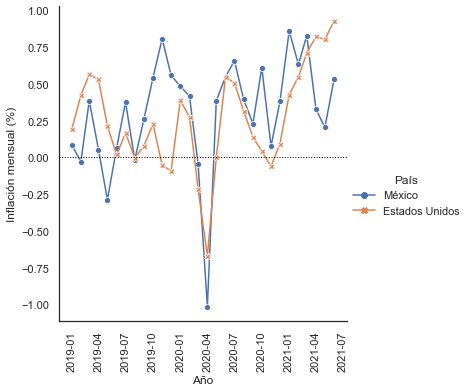

In [12]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Inflación mensual',
    kind = 'line',
    hue = 'País',
    style = 'País',
    markers = True,
    dashes = False,
    ci = None,
    data = ipc.query("País in ('México', 'Estados Unidos') & Fecha >= '2019-01-01'")
).set(
    xlabel = 'Año',
    ylabel = 'Inflación mensual (%)'
)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'inflacion_mensual')

Gráfico de la inflación mensual anualizada en México y Estados Unidos:

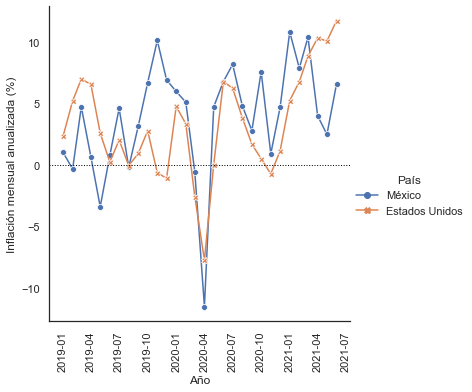

In [13]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Inflación anualizada',
    kind = 'line',
    hue = 'País',
    style = 'País',
    markers = True,
    dashes = False,
    ci = None,
    data = ipc.query("País in ('México', 'Estados Unidos') & Fecha >= '2019-01-01'")
).set(
    xlabel = 'Año',
    ylabel = 'Inflación mensual anualizada (%)'
)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'inflacion_mensual_anualizada')

Tabla de indicadores para 2021:

In [14]:
ipc.query("País in ('México', 'Estados Unidos') & Fecha >= '2021-01-01'").sort_values(['País', 'Fecha'])[[
    'País',
    'Periodo',
    'Inflación mensual',
    'Inflación anualizada',
    'Inflación anual'
]].style.hide_index()

País,Periodo,Inflación mensual,Inflación anualizada,Inflación anual
Estados Unidos,2021-01,0.425378,5.225675,4.308299
Estados Unidos,2021-02,0.547438,6.770709,4.308299
Estados Unidos,2021-03,0.708327,8.839012,4.308299
Estados Unidos,2021-04,0.821891,10.320967,4.308299
Estados Unidos,2021-05,0.801710,10.056278,4.308299
Estados Unidos,2021-06,0.929066,11.736501,4.308299
México,2021-01,0.859331,10.813589,3.429089
México,2021-02,0.632429,7.858771,3.429089
México,2021-03,0.826819,10.385691,3.429089
México,2021-04,0.327300,3.999080,3.429089


## 4. Ocupación y empleo

Para el análisis del empleo usamos la base de datos `enoe.csv`:

In [15]:
# Cargar base de datos:
enoe = pd.read_csv('bases_de_datos/enoe.csv')

# La función periodo_a_trimestre extrae el número de trimestre de un texto descriptivo:
def periodo_a_trimestre(s):
    trimestre = 0
    año = 0
    if s.find('Primer') == 0:
        trimestre = 1
    elif s.find('Segundo') == 0:
        trimestre = 2
    elif s.find('Tercer') == 0:
        trimestre = 3
    elif s.find('Cuarto') == 0:
        trimestre = 4
    return trimestre

# Extraer el número de trimestre y el año del texto descriptivo del periodo:
enoe['Trimestre'] = enoe['Periodo'].apply(periodo_a_trimestre)
enoe['Año'] = enoe['Periodo'].apply(lambda x: int(x[-4:]))

# Formatear el texto del periodo como 'YYYYQX' (por ejemplo, 2021Q1):
enoe['Periodo'] = enoe['Año'].apply(lambda x: str(x)) + "Q" + enoe['Trimestre'].apply(lambda x: str(x))

# Ordenar valores de forma ascendente:
enoe = enoe.sort_values(['Año', 'Trimestre'])

# Calcular variables de interés:
enoe['Tasa de ocupación'] = enoe['Población ocupada'] / enoe['Población económicamente activa'] * 100
enoe['Tasa de desocupación'] = 100 - enoe['Tasa de ocupación']
enoe['Tasa de ocupación (cambio)'] = enoe['Tasa de ocupación'].transform(lambda x: (x - x.shift()) / x.shift() * 100)
enoe['Tasa de desocupación (cambio)'] = enoe['Tasa de desocupación'].transform(lambda x: (x - x.shift()) / x.shift() * 100)
enoe['Población desocupada'] = enoe['Población económicamente activa'] - enoe['Población ocupada']
enoe['Población desocupada (cambio)'] = enoe['Población desocupada'] - enoe['Población desocupada'].shift()

Gráfico de la tasa de desocupación trimestral:

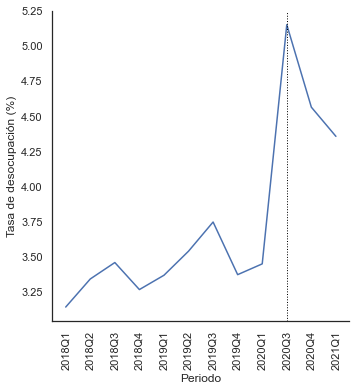

In [16]:
g = sns.relplot(
    x = 'Periodo',
    y = 'Tasa de desocupación',
    kind = 'line',
    markers = True,
    dashes = False,
    ci = None,
    data = enoe.query("Año >= 2018")
).set(
    xlabel = 'Periodo',
    ylabel = 'Tasa de desocupación (%)'
)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)
g.ax.axvline('2020Q3', color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'desocupacion')

Gráfico del cambio porcentual en la tasa de desocupación trimestral:

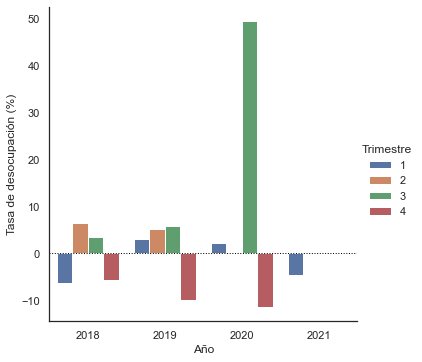

In [17]:
g = sns.catplot(
    x = 'Año',
    y = 'Tasa de desocupación (cambio)',
    kind = 'bar',
    hue = 'Trimestre',
    data = enoe.query("Año >= 2018")
).set(
    xlabel = 'Año',
    ylabel = 'Tasa de desocupación (%)'
)

g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'desocupacion_cambio')

Tabla con algunos indicadores trimestrales:

In [18]:
pd.DataFrame(enoe.query("Año >= 2018")[[
    'Periodo',
    'Tasa de informalidad laboral',
    'Tasa de desocupación',
    'Tasa de desocupación (cambio)',
    'Población desocupada',
    'Población desocupada (cambio)'
]]).style.format(formatter = {
    'Tasa de informalidad laboral': '{:.2f}%',
    'Tasa de desocupación': '{:.2f}%',
    'Tasa de desocupación (cambio)': '{:.2f}%',
    'Población desocupada': '{:,.0f}',
    'Población desocupada (cambio)': '{:,.0f}',
}).hide_index()

Periodo,Tasa de informalidad laboral,Tasa de desocupación,Tasa de desocupación (cambio),Población desocupada,Población desocupada (cambio)
2018Q1,56.70%,3.14%,-6.21%,"1,713,857","-116,936"
2018Q2,56.60%,3.34%,6.37%,"1,858,160","144,303"
2018Q3,56.70%,3.46%,3.50%,"1,934,278","76,118"
2018Q4,56.60%,3.26%,-5.57%,"1,828,591","-105,687"
2019Q1,56.90%,3.37%,3.12%,"1,886,205","57,614"
2019Q2,56.30%,3.54%,5.09%,"2,014,496","128,291"
2019Q3,56.50%,3.74%,5.87%,"2,147,638","133,142"
2019Q4,56.20%,3.37%,-10.00%,"1,942,071","-205,567"
2020Q1,56.10%,3.45%,2.28%,"1,976,060","33,989"
2020Q3,54.20%,5.15%,49.40%,"2,769,491","793,431"


¿Existe una relación entre la tasa de informalidad laboral y la tasa de desocupación? Gráficamente:

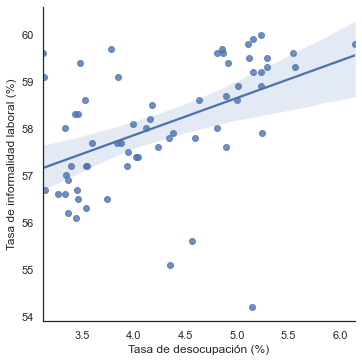

In [19]:
g = sns.lmplot(
    x = 'Tasa de desocupación',
    y = 'Tasa de informalidad laboral',
    data = enoe
).set(
    xlabel = 'Tasa de desocupación (%)',
    ylabel = 'Tasa de informalidad laboral (%)'
)

guardar(g, 'desocupacion_informalidad')

Resultados del modelo lineal ajustado:

In [20]:
print(sm.OLS(enoe['Tasa de informalidad laboral'], sm.add_constant(enoe['Tasa de desocupación'])).fit().summary())

                                 OLS Regression Results                                 
Dep. Variable:     Tasa de informalidad laboral   R-squared:                       0.225
Model:                                      OLS   Adj. R-squared:                  0.212
Method:                           Least Squares   F-statistic:                     17.98
Date:                          Tue, 03 Aug 2021   Prob (F-statistic):           7.56e-05
Time:                                  22:34:51   Log-Likelihood:                -99.178
No. Observations:                            64   AIC:                             202.4
Df Residuals:                                62   BIC:                             206.7
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------

¿Existe una relación entre la tasa de informalidad laboral y la tasa de desocupación rezagada? Al ajustar modelos para 1, 2, 3 y 4 rezagos (trimestres), que corresponden a 1, 6, 9 y 12 meses, se obtienen los siguientes valores de $R^2$:

In [21]:
# Crear una copia de la base de datos:
enoe2 = enoe

# Calcular rezagos y limpiar observaciones vacías:
enoe2['Tasa de desocupación (lag 1)'] = enoe2['Tasa de desocupación'].shift(periods = 1)
enoe2['Tasa de desocupación (lag 2)'] = enoe2['Tasa de desocupación'].shift(periods = 2)
enoe2['Tasa de desocupación (lag 3)'] = enoe2['Tasa de desocupación'].shift(periods = 3)
enoe2['Tasa de desocupación (lag 4)'] = enoe2['Tasa de desocupación'].shift(periods = 4)
enoe2 = enoe2.dropna()

# Mostrar resultados (R cuadradas):
print(1, '-', sm.OLS(enoe2['Tasa de informalidad laboral'], sm.add_constant(enoe2['Tasa de desocupación (lag 1)'])).fit().rsquared)
print(2, '-', sm.OLS(enoe2['Tasa de informalidad laboral'], sm.add_constant(enoe2['Tasa de desocupación (lag 2)'])).fit().rsquared)
print(3, '-', sm.OLS(enoe2['Tasa de informalidad laboral'], sm.add_constant(enoe2['Tasa de desocupación (lag 3)'])).fit().rsquared)
print(4, '-', sm.OLS(enoe2['Tasa de informalidad laboral'], sm.add_constant(enoe2['Tasa de desocupación (lag 4)'])).fit().rsquared)

1 - 0.4186166534889817
2 - 0.3777697584325962
3 - 0.4437588458037357
4 - 0.37136700685779844


Gráficamente:

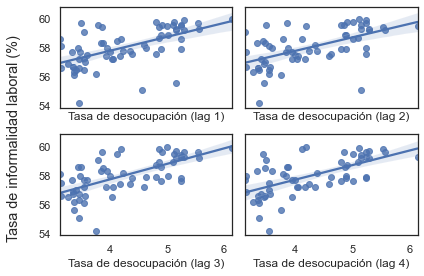

In [22]:
fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)

sns.regplot(ax = axes[0, 0], x = 'Tasa de desocupación (lag 1)', y = 'Tasa de informalidad laboral', data = enoe).set(ylabel = None)
sns.regplot(ax = axes[0, 1], x = 'Tasa de desocupación (lag 2)', y = 'Tasa de informalidad laboral', data = enoe).set(ylabel = None)
sns.regplot(ax = axes[1, 0], x = 'Tasa de desocupación (lag 3)', y = 'Tasa de informalidad laboral', data = enoe).set(ylabel = None)
sns.regplot(ax = axes[1, 1], x = 'Tasa de desocupación (lag 4)', y = 'Tasa de informalidad laboral', data = enoe).set(ylabel = None)
fig.supylabel('Tasa de informalidad laboral (%)')
fig.tight_layout()

guardar(fig, 'desocupacion_informalidad_lag')

## 5. Indicadores de corto plazo

Para el análisis de indicadores de corto plazo utilizamos la base de datos `indicadores_corto_plazp.csv`:

In [23]:
# Cargar base de datos:
indicadores = pd.read_csv('bases_de_datos/indicadores_corto_plazo.csv')

# Transformar los datos de formato wide a long:
indicadores = indicadores.melt(id_vars = 'Indicador', var_name = 'Periodo', value_name = 'Índice')

# Extraer una fecha válida de la variable 'Periodo':
indicadores['Fecha'] = indicadores['Periodo'].apply(lambda x: x.split('M')[0] + "-" + x.split('M')[1] + "-1")
indicadores['Fecha'] = pd.to_datetime(indicadores['Fecha'])

# Calcular crecimiento respecto al mes anterior y al mes correspondiente del año anterior:
indicadores = indicadores.sort_values('Fecha')
indicadores['Crecimiento respecto al mes anterior'] = indicadores['Índice'].groupby(indicadores['Indicador']).transform(lambda x: (x - x.shift(periods=1)) / x.shift(periods=1) * 100)
indicadores['Crecimiento respecto al mismo mes del año anterior'] = indicadores['Índice'].groupby(indicadores['Indicador']).transform(lambda x: (x - x.shift(periods=12)) / x.shift(periods=12) * 100)

# Limpiar observaciones vacías:
indicadores = indicadores.dropna()

Indicadores disponibles:

In [24]:
# Mostrar la tabla de indicadores disponibles en la base de datos:
pd.DataFrame({'Indicador': indicadores['Indicador'].unique()}).sort_values('Indicador').style.hide_index()

Indicador
Consumo privado (total)
Consumo privado importaciones
Consumo privado nacional (bienes)
Consumo privado nacional (servicios)
Consumo privado nacional (total)
IGAE
IGAE (actividades primarias)
IGAE (actividades secundarias)
IGAE (actividades terciarias)
IMAI


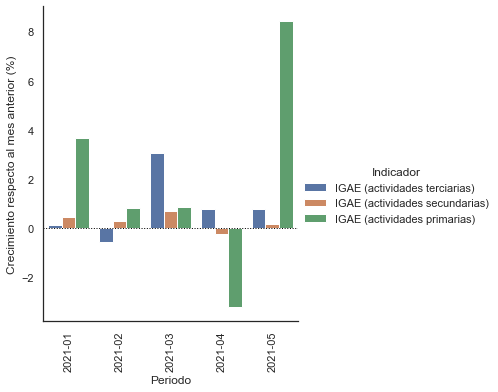

In [25]:
g = sns.catplot(
    x = 'Fecha',
    y = 'Crecimiento respecto al mes anterior',
    kind = 'bar',
    hue = 'Indicador',
    data = indicadores.query("Indicador in ('IGAE (actividades primarias)', 'IGAE (actividades secundarias)', 'IGAE (actividades terciarias)') & Fecha >= '2021-01-01'")
).set(
    xlabel = 'Periodo',
    ylabel = 'Crecimiento respecto al mes anterior (%)'
)

xlabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m') for x in g.ax.get_xticklabels()]
g.ax.set_xticklabels(xlabels, rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'indicadores_igae_por_actividad')

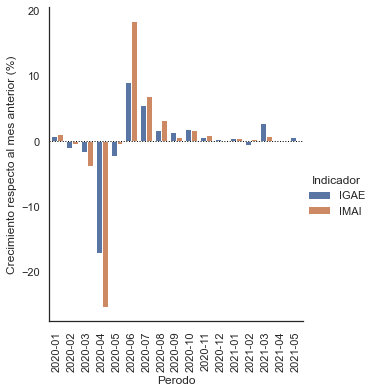

In [26]:
g = sns.catplot(
    x = 'Fecha',
    y = 'Crecimiento respecto al mes anterior',
    kind = 'bar',
    hue = 'Indicador',
    data = indicadores.query("Indicador in ('IGAE', 'IMAI') & Fecha >= '2020-01-01'")
).set(
    xlabel = 'Perodo',
    ylabel = 'Crecimiento respecto al mes anterior (%)'
)

xlabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m') for x in g.ax.get_xticklabels()]
g.ax.set_xticklabels(xlabels, rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'indicadores_igae_imai')

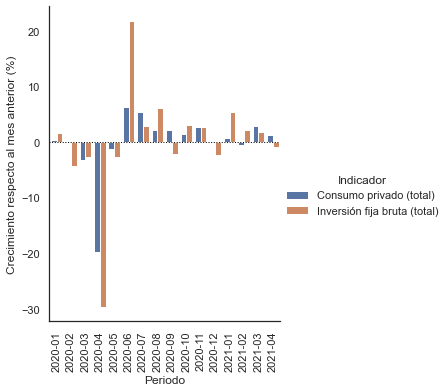

In [27]:
g = sns.catplot(
    x = 'Fecha',
    y = 'Crecimiento respecto al mes anterior',
    kind = 'bar',
    hue = 'Indicador',
    data = indicadores.query("Indicador in ('Consumo privado (total)', 'Inversión fija bruta (total)') & Fecha >= '2020-01-01'")
).set(
    xlabel = 'Periodo',
    ylabel = 'Crecimiento respecto al mes anterior (%)'
)

xlabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m') for x in g.ax.get_xticklabels()]
g.ax.set_xticklabels(xlabels, rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'indicadores_consumo_inversion')

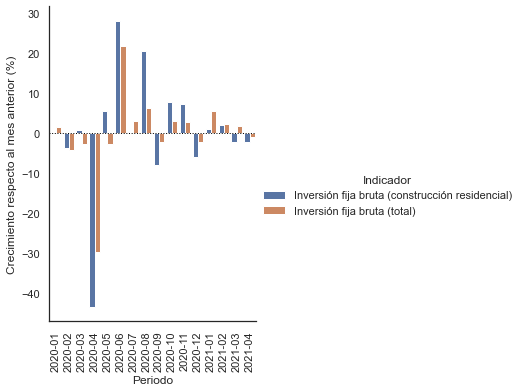

In [28]:
g = sns.catplot(
    x = 'Fecha',
    y = 'Crecimiento respecto al mes anterior',
    kind = 'bar',
    hue = 'Indicador',
    data = indicadores.query("Indicador in ('Inversión fija bruta (construcción residencial)', 'Inversión fija bruta (total)') & Fecha >= '2020-01-01'")
).set(
    xlabel = 'Periodo',
    ylabel = 'Crecimiento respecto al mes anterior (%)'
)

xlabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m') for x in g.ax.get_xticklabels()]
g.ax.set_xticklabels(xlabels, rotation = 90)
g.ax.axhline(0, color = 'black', linewidth = '1', linestyle = 'dotted')

guardar(g, 'indicadores_inversion_construccion_residencial')

In [29]:
ind = (
    'IGAE',
    'IGAE (actividades primarias)',
    'IGAE (actividades secundarias)',
    'IGAE (actividades terciarias)',
)

indicadores.query("Indicador in " + str(ind) + " & Fecha >= '2021-01-01'").sort_values(['Periodo', 'Indicador']).style.format(formatter = {
    'Crecimiento respecto al mes anterior': '{:.2f}%',
    'Crecimiento respecto al mismo mes del año anterior': '{:.2f}%',
}).hide_columns(['Fecha', 'Índice']).hide_index()

Indicador,Periodo,Crecimiento respecto al mes anterior,Crecimiento respecto al mismo mes del año anterior
IGAE,2021M1,0.40%,-4.19%
IGAE (actividades primarias),2021M1,3.65%,2.23%
IGAE (actividades secundarias),2021M1,0.45%,-3.84%
IGAE (actividades terciarias),2021M1,0.10%,-4.59%
IGAE,2021M2,-0.61%,-3.74%
IGAE (actividades primarias),2021M2,0.82%,7.62%
IGAE (actividades secundarias),2021M2,0.26%,-3.11%
IGAE (actividades terciarias),2021M2,-0.59%,-4.77%
IGAE,2021M3,2.66%,0.54%
IGAE (actividades primarias),2021M3,0.83%,-0.44%


In [30]:
ind = (
    'IMAI',
    'IMAI (construcción)',
    'IMAI (electricidad, agua, gas)',
    'IMAI (manufactura)',
    'IMAI (minería)'
)

indicadores.query("Indicador in " + str(ind) + " & Fecha >= '2021-01-01'").sort_values(['Periodo', 'Indicador']).style.format(formatter = {
    'Crecimiento respecto al mes anterior': '{:.2f}%',
    'Crecimiento respecto al mismo mes del año anterior': '{:.2f}%',
}).hide_columns(['Fecha', 'Índice']).hide_index()

Indicador,Periodo,Crecimiento respecto al mes anterior,Crecimiento respecto al mismo mes del año anterior
IMAI,2021M1,0.45%,-3.84%
IMAI (construcción),2021M1,2.36%,-10.42%
"IMAI (electricidad, agua, gas)",2021M1,-1.67%,-4.80%
IMAI (manufactura),2021M1,-0.60%,-0.99%
IMAI (minería),2021M1,0.74%,-3.50%
IMAI,2021M2,0.26%,-3.11%
IMAI (construcción),2021M2,2.81%,-5.28%
"IMAI (electricidad, agua, gas)",2021M2,-4.22%,-9.76%
IMAI (manufactura),2021M2,-2.24%,-3.00%
IMAI (minería),2021M2,3.08%,0.42%


In [31]:
ind = (
    'Consumo privado (total)',
    'Consumo privado nacional (total)',
    'Consumo privado nacional (bienes)',
    'Consumo privado nacional (servicios)',
    'Consumo privado importaciones'
)

indicadores.query("Indicador in " + str(ind) + " & Fecha >= '2021-01-01'").sort_values(['Periodo', 'Indicador']).style.format(formatter = {
    'Crecimiento respecto al mes anterior': '{:.2f}%',
    'Crecimiento respecto al mismo mes del año anterior': '{:.2f}%',
}).hide_columns(['Fecha', 'Índice']).hide_index()

Indicador,Periodo,Crecimiento respecto al mes anterior,Crecimiento respecto al mismo mes del año anterior
Consumo privado (total),2021M1,0.75%,-6.15%
Consumo privado importaciones,2021M1,3.57%,3.99%
Consumo privado nacional (bienes),2021M1,0.87%,-0.27%
Consumo privado nacional (servicios),2021M1,-0.01%,-14.18%
Consumo privado nacional (total),2021M1,0.59%,-7.21%
Consumo privado (total),2021M2,-0.47%,-6.59%
Consumo privado importaciones,2021M2,-1.15%,3.03%
Consumo privado nacional (bienes),2021M2,0.03%,-0.75%
Consumo privado nacional (servicios),2021M2,0.45%,-14.12%
Consumo privado nacional (total),2021M2,-0.61%,-7.74%


In [32]:
ind = (
    'Inversión fija bruta (total)',
    'Inversión fija bruta (construcción total)',
    'Inversión fija bruta (construcción residencial)',
    'Inversión fija bruta (construcción no residencial)',
    'Inversión fija bruta (maquinaria y equipo)'
)

indicadores.query("Indicador in " + str(ind) + " & Fecha >= '2021-01-01'").sort_values(['Periodo', 'Indicador']).style.format(formatter = {
    'Crecimiento respecto al mes anterior': '{:.2f}%',
    'Crecimiento respecto al mismo mes del año anterior': '{:.2f}%',
}).hide_columns(['Fecha', 'Índice']).hide_index()

Indicador,Periodo,Crecimiento respecto al mes anterior,Crecimiento respecto al mismo mes del año anterior
Inversión fija bruta (construcción no residencial),2021M1,7.77%,-15.61%
Inversión fija bruta (construcción residencial),2021M1,1.10%,-9.29%
Inversión fija bruta (construcción total),2021M1,3.76%,-12.42%
Inversión fija bruta (maquinaria y equipo),2021M1,4.66%,-4.65%
Inversión fija bruta (total),2021M1,5.43%,-9.68%
Inversión fija bruta (construcción no residencial),2021M2,1.97%,-9.79%
Inversión fija bruta (construcción residencial),2021M2,1.98%,-3.79%
Inversión fija bruta (construcción total),2021M2,2.57%,-6.71%
Inversión fija bruta (maquinaria y equipo),2021M2,1.78%,2.09%
Inversión fija bruta (total),2021M2,2.19%,-3.56%


## 6. Mercado financiero y de crédito

Utilizaremos las bases de datos:
* `tasa_hipoteca_adquisicion.csv` con la tasa promedio ponderada de créditos hipotecarios vigentes (no vencidos) para adquisición de vivienda.
* `creditos_hipotecarios_otorgados.csv` con el número total de créditos hipotecarios otorgados por instituciones bancarias.
* `tiie.csv` con la tasa de interés interbanciaria de equilibrio a un día publicada por el Banco de México, tanto observada como objetivo.

In [33]:
# Cargar base de datos de tasas hipotecarias y de créditos otorgados:
hip = pd.read_csv('bases_de_datos/tasa_hipoteca_adquisicion.csv')
cre = pd.read_csv('bases_de_datos/creditos_hipotecarios_otorgados.csv')

# Convertir variable 'Fecha' a tipo datetime():
hip['Fecha'] = pd.to_datetime(hip['Fecha'])
cre['Fecha'] = pd.to_datetime(cre['Fecha'])

# Transformar los datos de formato wide a long:
hip = hip.melt(id_vars = 'Fecha', var_name = 'Institución', value_name = 'Tasa')

# Calcular tasa mínima, máxima y promedio (por fecha):
hip['TH mínima'] = hip['Tasa'].groupby(hip['Fecha']).transform(min)
hip['TH máxima'] = hip['Tasa'].groupby(hip['Fecha']).transform(max)
hip['TH promedio'] = hip['Tasa'].groupby(hip['Fecha']).transform(np.mean)

# Eliminar registros duplicados y volver a transformar a formato long:
hip = hip[['Fecha', 'TH mínima', 'TH máxima', 'TH promedio']].drop_duplicates()
hip = hip.melt(id_vars = 'Fecha', var_name = 'Clase', value_name = 'Tasa')

# Cargar base de datos de TIIE:
tiie = pd.read_csv('bases_de_datos/tiie.csv')

# Convertir variable 'Fecha' a tipo datetime():
tiie['Fecha'] = pd.to_datetime(tiie['Fecha'])

# Conservar sólo la TIE objetivo:
tiie = tiie.drop('TIIE (un día)', axis = 'columns')

# Transformar los datos de formato wide a long:
tiie = tiie.melt(id_vars = 'Fecha', var_name = 'Clase', value_name = 'Tasa')

# Convertir tasa a formato numérico:
tiie['Tasa'] = pd.to_numeric(tiie['Tasa'])

# Eliminar faltantes y conservar las fechas para las cuales hay una tasa hipotecaria correspondiente:
tiie = tiie.dropna()
tiie = tiie.query("Fecha in " + str(tuple(pd.to_datetime(x).strftime('%Y-%m-%d') for x in hip['Fecha'].unique())))

# Unir ambas bases de datos:
hip = hip.append(tiie)
cre = cre.merge(tiie).drop('Clase', axis = 'columns')

Gráfico de la tasa hipotecaria (mínima, máxima, promedio) y la TIIE objetivo del Banco de México:

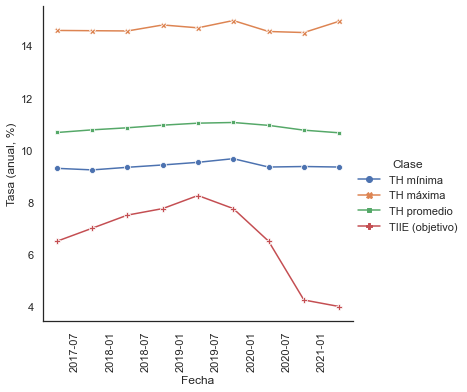

In [34]:
g = sns.relplot(
    x = 'Fecha',
    y = 'Tasa',
    kind = 'line',
    hue = 'Clase',
    style = 'Clase',
    markers = True,
    dashes = False,
    ci = None,
    data = hip
).set(
    xlabel = 'Fecha',
    ylabel = 'Tasa (anual, %)'
)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation = 90)

guardar(g, 'tasa_hipotecaria_tiie')

Gráfico del número de créditos otorgados vs. TIIE objetivo:

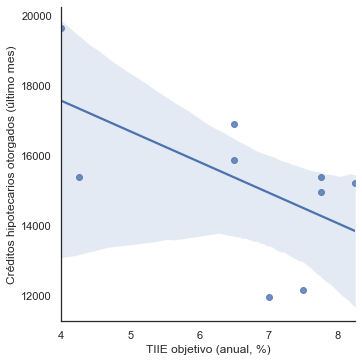

In [35]:
g = sns.lmplot(
    x = 'Tasa',
    y = 'Total',
    data = cre
).set(
    xlabel = 'TIIE objetivo (anual, %)',
    ylabel = 'Créditos hipotecarios otorgados (último mes)'
)

guardar(g, 'creditos_hipotecarios_tiie')

Tabla de créditos otorgados y TIIE objetivo:

In [36]:
cre.sort_values('Fecha').style.format(formatter = {
    'Total': '{:,}',
    'Tasa': '{:.2f}%'
}).hide_index()

Fecha,Total,Tasa
2017-03-31 00:00:00,"16,899",6.50%
2017-09-30 00:00:00,"11,939",7.00%
2018-03-31 00:00:00,"12,151",7.50%
2018-09-30 00:00:00,"14,949",7.75%
2019-03-31 00:00:00,"15,223",8.25%
2019-09-30 00:00:00,"15,370",7.75%
2020-03-31 00:00:00,"15,878",6.50%
2020-09-30 00:00:00,"15,386",4.25%
2021-03-31 00:00:00,"19,650",4.00%
